# Pokemon Classify Pytorch Lightning CNN

In [3]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [ ]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [30]:
class PokemonDataModule(Dataset):
    def __init__(self, data_dir, transform):
        self.dataset = ImageFolder(root=data_dir, transform=transform)
        self.class_names = self.dataset.classes
        self.stats = None

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def plot_examples(self,
                      n_rows=1,
                      n_cols=4):
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 8))
        for i, ax in enumerate(axes.flat):
            idx = np.random.randint(0, len(self.dataset))
            img, label = self.dataset[idx]
            ax.imshow(img.permute(1, 2, 0))  # Convert CHW to HWC
            ax.set_title(self.class_names[label])
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    def _get_stats(self, dataset):
        """
        Calculate the mean and standard deviation of the dataset for standardization.
        """
        dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)
        total_sum, total_squared_sum, total_count = 0, 0, 0
        with torch.cuda.device(0):
            for data, _ in dataloader:
                data.cuda()
                total_sum += data.sum(dim=(0, 2, 3))
                total_squared_sum += (data ** 2).sum(dim=(0, 2, 3))
                total_count += data.size(0) * data.size(2) * data.size(3)
    
            means = total_sum / total_count
            stds = torch.sqrt((total_squared_sum / total_count) - (means ** 2))
        return means, stds

    def prepare_data(self,
                     indices_file='indices.pkl',
                     stats=None
                    ):
        """
        Prepare train and test dataloaders with optional transformations.
        
        Args:
            indices_file (str): Path to save or load train/test indices.
            transform (callable): Primary transformation to apply to the data.
            additional_transforms (callable): Additional transformations to compose.
        
        Returns:
            tuple: trainloader, testloader
        """
        try:
            with open(indices_file, 'rb') as f:
                self.train_indices, self.test_indices = pickle.load(f)
        except (EOFError, FileNotFoundError):
            # Generate new indices if file is empty or doesn't exist
            self.train_indices, self.test_indices = train_test_split(
                range(len(self.dataset)),
                test_size=0.2,
                stratify=self.dataset.targets,
                random_state=42
            )
            
            # Ensure directory exists before saving
            os.makedirs(os.path.dirname(indices_file) or '.', exist_ok=True)
            
            with open(indices_file, 'wb') as f:
                pickle.dump([self.train_indices, self.test_indices], f)

        # Prepare train and test subsets
        self.train_dataset = Subset(self.dataset, self.train_indices)
        self.test_dataset = Subset(self.dataset, self.test_indices)
        
        self.stats = stats if stats is not None else self._get_stats(self.train_dataset)

    def get_dataloaders(self,
                        indices_file='indices.pkl',
                        transform=None,
                        train_batch_size=None,
                        validation_batch_size = None):
        """
        Prepare train and test dataloaders with optional transformations.

        Args:
            indices_file (str): Path to save or load train/test indices.
            transform (callable): Primary transformation to apply to the data.
            additional_transforms (callable): Additional transformations to compose.
            batch_size (int): Batch size for DataLoader. Defaults to the class-defined batch size.

        Returns:
            tuple: trainloader, testloader
        """
        assert self.train_dataset is not None, f'You first need to call {...} prepare_data before being able to '
            
        validation_batch_size = train_batch_size if validation_batch_size is None else validation_batch_size

        # Apply transformations if provided
        if transform:
            train_dataset.dataset.transform = transform
        if additional_transforms:
            from torchvision.transforms import Compose
            train_dataset.dataset.transform = Compose([transform] + additional_transforms)

        trainloader = DataLoader(self.train_dataset, batch_size=train_batch_size, shuffle=True)
        testloader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)

        return trainloader, testloader

In [31]:
# Define the dataset and transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor(),       # Convert PIL images to tensors
])

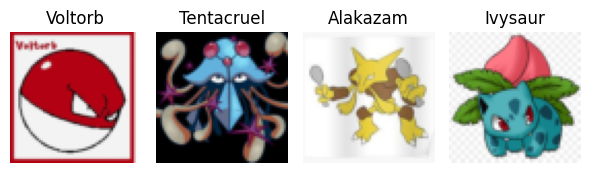

In [33]:
DATA_DIR = "/kaggle/input/PokemonData"

pokemon_dataset = PokemonDataModule(DATA_DIR, transform)
pokemon_dataset.plot_examples()

In [ ]:
# Get class names
print(f"Number of classes: {len(pokemon_dataset.class_names)}")

In [38]:
chanel_means = torch.tensor([0.6062, 0.5889, 0.5550])
chanel_vars = torch.tensor([0.3284, 0.3115, 0.3266])
stats = (chanel_means, chanel_vars)
pokemon_dataset.prepare_data(stats=stats)

In [39]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")